# トイレ掃除双腕ロボット制御実験群

## ROS 2 for xArm 利用上の注意

### ノードの立ち上げ(Wake Up Nodes for xArms)

xArmのROSコマンドは、それぞれ別ターミナルで予め実行しておくこと
```
term1# ros2 launch xarm_api xarm7_driver.launch.py robot_ip:=192.168.0.95 hw_ns:=left
term2# ros2 launch xarm_api xarm7_driver.launch.py robot_ip:=192.168.0.97 hw_ns:=right
```

### [初回立ち上げ時]必要なサービスの有効化 ( Some configure after "colcon build")

position_aaなど、デフォルトでは使用していないserviceを使っている

そのため、~/dev_ws/install側にxarm_user_config.yamlを新規作成、必要なサービスを有効しておくこと

### 自走台車 (For scart V100)

term3$ ros2 run ros1_bridge dynamic_bridge

term4$ ros2 topic pub /cmd_vel geometry_msgs/Twist '{linear: {x: 0.001, y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: 0.0}}'


In [1]:
## Libraries
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import Image
from std_msgs.msg import String
from cv_bridge import CvBridge, CvBridgeError
import cv2
import numpy as np
import time
from xarm_msgs.srv import SetInt16ById,SetInt16, MoveCartesian, MoveJoint, MoveVelocity
from xarm_msgs.msg import RobotMsg
from matplotlib import pyplot as plt
import cv2

from scipy import interpolate # 欠損データの補完


import json

In [2]:
### xArm Setup Client
# This class is used to setup the xArm robot. It enables all joints and sets the proper mode and state.
# The mode is set to 0 (position mode) and the state is set to 0 (ready).
# The class also provides methods to change the mode to handteach and velocity mode.
# The handteach mode is mode 2 and the velocity mode is mode 5.

class XArmSetupClient(Node):
    def __init__(self,hw_ns):
        super().__init__('xarm_setup_client')

        self.hw_ns = hw_ns
        # Enable all joints
        self.motion_enable_client = self.create_client(SetInt16ById, f'/{self.hw_ns}/motion_enable')
        self.motion_enable_request = SetInt16ById.Request()
        self.motion_enable_request.id = 8
        self.motion_enable_request.data = 1

        # Set proper mode and state
        self.set_mode_client = self.create_client(SetInt16, f'/{self.hw_ns}/set_mode')
        self.set_mode_request = SetInt16.Request()
        self.set_mode_request.data = 0

        self.set_state_client = self.create_client(SetInt16, f'/{self.hw_ns}/set_state')
        self.set_state_request = SetInt16.Request()
        self.set_state_request.data = 0
        self.call_services(mode = 0)

    def call_services(self, mode = 0):
        time.sleep(0.2) # TODO:左右同時におくるとパケロスが生じるような挙動をするためのバッドノウハウ
        # Enable all joints
        if not self.motion_enable_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/motion_enable is not available!')
            return
        self.motion_enable_client.call_async(self.motion_enable_request)

        # Set mode and state
        self.set_mode_request.data = mode
        
        if not self.set_mode_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_mode is not available!')
            return
        self.set_mode_client.call_async(self.set_mode_request)

        if not self.set_state_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_state is not available!')
            return
        self.set_state_client.call_async(self.set_state_request)

    def call_mode_handteach(self):
        self.call_services(mode = 2)

    def call_mode_position(self):
        self.call_services(mode = 0)
        
    def call_mode_vel(self):
        self.call_services(mode = 5)



In [3]:
import time

In [4]:
import ipywidgets as widgets

In [5]:
## xArm State Subscriber
# This class is used to subscribe to the xArm state topic. It stores the current state of the xArm robot.
# The state is stored in the xarm_state variable.
class xArmStateSubscriber(Node):
        def __init__(self,hw_ns):
            super().__init__('xarm_state_subscriber')

            self.hw_ns = hw_ns
            self.subscription = self.create_subscription(
                RobotMsg,
                f'/{self.hw_ns}/robot_states',
                self.listener_callback,
                10)
            self.subscription  # prevent unused variable warning
            self.xarm_state = RobotMsg()
    
        def listener_callback(self, msg):
            self.xarm_state = msg
            #self.get_logger().info(f'xarm state: {msg}')

## xArm Service Client
# This class is used to send requests to the xArm robot. It provides methods to move the robot in cartesian and joint space.
# The methods send_move_cartesian_request and send_joint_move_request are used to move the robot in cartesian and joint space respectively.
# The methods send_move_cartesian_relative_request and send_joint_move_relative_request are used to move the robot in cartesian and joint space relatively.
# The method send_vel_request is used to set the velocity of the robot.
class XArmServiceClient(Node):

    def __init__(self,hw_ns):
        super().__init__('xarm_service_client')
        self.hw_ns = hw_ns
        # Cartesian linear motion
        self.set_position_client = self.create_client(MoveCartesian, f'/{self.hw_ns}/set_position')
        self.set_tool_position_client = self.create_client(MoveCartesian, f'/{self.hw_ns}/set_tool_position')
        self.set_position_aa_client = self.create_client(MoveCartesian, f'/{self.hw_ns}/set_position_aa')

        # Service that specifies axes. If only a coordinate system is given, it may be executed in an unintended posture.
        self.set_joint_client = self.create_client(MoveJoint, f'/{self.hw_ns}/set_servo_angle')

    def send_move_cartesian_request(self, pose, speed, acc, mvtime):
        # Set position
        if not self.set_position_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_position_client.call_async(request)

    def send_move_cartesian_aa_request(self, pose, speed, acc, mvtime, is_tool_coord=True, is_wait=True):
        # Set position
        if not self.set_position_aa_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position_aa is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = is_wait
        request.is_tool_coord = is_tool_coord
        
        # 非同期でサービスをコール
        self.future = self.set_position_aa_client.call_async(request)

    def send_move_cartesian_aa_relative_request(self, pose, speed, acc, mvtime, is_tool_coord=True):
        # Set position
        if not self.set_position_aa_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position_aa is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True
        request.relative = True
        request.is_tool_coord = is_tool_coord
        
        # 非同期でサービスをコール
        self.future = self.set_position_aa_client.call_async(request)

    
    def send_move_tool_positon_request(self, pose, speed, acc, mvtime, is_tool_coord=True):
        # Set position
        if not self.set_tool_position_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_tool_position is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True
        request.is_tool_coord = is_tool_coord
        
        # 非同期でサービスをコール
        self.future = self.set_tool_position_client.call_async(request)

    
    def send_move_cartesian_relative_request(self, pose, speed, acc, mvtime):
        # Set position
        if not self.set_position_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.relative = True
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_position_client.call_async(request)

    def send_joint_move_request(self, joint, speed, acc, mvtime):
        # Set position
        if not self.set_joint_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_servo_angle is not available!')
            return
        
        request = MoveJoint.Request()
        request.angles = joint
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_joint_client.call_async(request)

    def send_joint_move_relative_request(self, joint, speed, acc, mvtime):
        # Set position
        if not self.set_joint_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_servo_angle is not available!')
            return
        
        request = MoveJoint.Request()
        request.angles = joint
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.relative = True
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_joint_client.call_async(request)

    def send_vel_request(self,vel_linear_x, vel_linear_y, vel_linear_z, vel_linear_roll, vel_linear_pitch, vel_angular_yaw):
        ### Velocity Move
        ## TODO: Time limits should be set. Otherwise, it will run infinitely until an error occurs.
        request = MoveVelocity.Request()
        request.speeds = [vel_linear_x, vel_linear_y, vel_linear_z, vel_linear_roll, vel_linear_pitch, vel_angular_yaw]

        # 非同期でサービスをコール
        self.future = self.set_position_client.call_async(request)


In [6]:
rclpy.init() # Initialize the rclpy library

In [7]:
# UI for experimenting with travel distances for self-propelled robots.
# The values moved by the slider are set as various parameters.

# Set distination (vel)
value_dist = 0.0

float_range = widgets.FloatSlider(
    value=0.1,
    min=-1.0,
    max=1.0,
    step=0.01,
    description='Scart X value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

float_range.layout.width = '80%'

value_dist = float_range.value

def update_value(change):
    global value_dist
    value_dist = change.new

# Monitor slider value changes
float_range.observe(update_value, names='value')


#############
## Set Angle
value_angle = 0.0

float_angle = widgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.1,
    description='Scart Z angle:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

float_angle.layout.width = '80%'

value_angle = float_angle.value

def update_angle(change):
    global value_angle
    value_angle = change.new

# Monitor slider value changes
float_angle.observe(update_angle, names='value')


# Show widgets
widgets.VBox([float_range, float_angle])

In [8]:
#### Testing AGVs
## ex)ros2 topic pub /cmd_vel geometry_msgs/Twist '{linear: {x: 0.1, y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: 0.0}}'

def execute_remote_command(change):
    i = value_dist
    j = value_angle

    print(f"i: {i}, j: {j}")
    cmd = 'ros2 topic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: ' + str(i) + ', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: ' + str(j) + '}}"'
    #cmd = 'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: ' + str(i) + ', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: ' + str(j) + '}}"'
    #stdin, stdout, stderr = client.exec_command(cmd)

    # コマンドの実行結果を出力
    print(stdout.read().decode())

# Buttonウィジェットを作成
execute_button = widgets.Button(description="Execute")
execute_button.on_click(execute_remote_command)

# ウィジェットを表示
widgets.VBox([execute_button])

In [9]:
"""
#### Scart実験
## Way there AND Way Out

## 行き
def execute_way_there_command(change):
    pathdata = [
        [0.5,0.0],
        [0.4,0.0],
        [0.3,0.0],
        [0.0,1.0],
        [0.0,0.7],
        [0.15,0.0],
        [0.1,0.0]
    ]
    
    for pd in pathdata:
        i = pd[0]
        j = pd[1]
        print(f"X:{pd[0]}, YAW:{pd[1]}")
    
        # リモートでコマンドを実行
        cmd = 'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: ' + str(i) + ', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: ' + str(j) + '}}"'
        stdin, stdout, stderr = client.exec_command(cmd)
        time.sleep(3)

## 戻り
def execute_way_out_command(change):
    pathdata = [
        [-0.15,0.0],   
        [-0.1,0.0],   
        [0.0,1.0],
        [0.0,0.7],
        [0.5,0.0],
        [0.4,0.0],
        [0.2,0.0],
        [0.0,-1.0],
        [0.0,-1.0],
        [0.0,-1.0],
        [0.0,-0.4]
    ]
    for pd in pathdata:
        i = pd[0]
        j = pd[1]
        print(f"X:{pd[0]}, YAW:{pd[1]}")
    
        # リモートでコマンドを実行
        cmd = 'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: ' + str(i) + ', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: ' + str(j) + '}}"'
        stdin, stdout, stderr = client.exec_command(cmd)
        time.sleep(3)
    


# Buttonウィジェットを作成
execute_way_there_button = widgets.Button(description="行き")
execute_way_there_button.on_click(execute_way_there_command)

execute_way_out_button = widgets.Button(description="帰り")
execute_way_out_button.on_click(execute_way_out_command)

# ウィジェットを表示
#widgets.VBox([execute_way_there_button, execute_way_out_button])
widgets.VBox([execute_way_there_button])


"""

'\n#### Scart実験\n## Way there AND Way Out\n\n## 行き\ndef execute_way_there_command(change):\n    pathdata = [\n        [0.5,0.0],\n        [0.4,0.0],\n        [0.3,0.0],\n        [0.0,1.0],\n        [0.0,0.7],\n        [0.15,0.0],\n        [0.1,0.0]\n    ]\n    \n    for pd in pathdata:\n        i = pd[0]\n        j = pd[1]\n        print(f"X:{pd[0]}, YAW:{pd[1]}")\n    \n        # リモートでコマンドを実行\n        cmd = \'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: \' + str(i) + \', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: \' + str(j) + \'}}"\'\n        stdin, stdout, stderr = client.exec_command(cmd)\n        time.sleep(3)\n\n## 戻り\ndef execute_way_out_command(change):\n    pathdata = [\n        [-0.15,0.0],   \n        [-0.1,0.0],   \n        [0.0,1.0],\n        [0.0,0.7],\n        [0.5,0.0],\n        [0.4,0.0],\n        [0.2,0.0],\n        [0.0,-1.0],\n        [0.0,-1.0],\n        [0.0,-1.0],\n        [0.0,-0.4]\n    ]\n    for pd in pathdata:\n        i = pd[0]\n        j =

In [10]:
# Create the xArm setup clients. These clients are used to setup the xArm robot.
xarm_right_setup_client = XArmSetupClient(hw_ns='right')
xarm_left_setup_client = XArmSetupClient(hw_ns='left')


[WARN] [1714738989.913430003] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


In [11]:
## Create the xArm service clients. These clients are used to send requests to the xArm robot.
# For Right Arm
xarm_right_service_client = XArmServiceClient(hw_ns='right')
xarm_right_state_subscriber = xArmStateSubscriber(hw_ns='right')
# For Left Arm
xarm_left_service_client = XArmServiceClient(hw_ns='left')
xarm_left_state_subscriber = xArmStateSubscriber(hw_ns='left')

[WARN] [1714738993.174772595] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1714738993.189680575] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


In [12]:
# Call state subscriber to get the current state of the xArm robot Right Arm
rclpy.spin_once(xarm_right_state_subscriber)
print(xarm_right_state_subscriber.xarm_state)
#xarm_right_state_subscriber.xarm_state.pose
#xarm_right_state_subscriber.xarm_state.angle
#xarm_right_state_subscriber.xarm_state.state

xarm_msgs.msg.RobotMsg(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1714738994, nanosec=810718374), frame_id=''), state=4, mode=0, cmdnum=0, mt_brake=127, mt_able=127, err=0, warn=0, angle=[-0.366916686296463, -1.0819416046142578, 0.9168603420257568, 0.5016922354698181, -2.4272255897521973, 2.7748119831085205, 0.29482728242874146], pose=array([ 4.4694885e+02,  1.9416910e+02,  3.2699655e+02, -1.4670919e-01,
       -2.3589389e-01,  3.7212020e-01], dtype=float32), offset=array([0., 0., 0., 0., 0., 0.], dtype=float32))


In [13]:
# Call state subscriber to get the current state of the xArm robot Left Arm
rclpy.spin_once(xarm_left_state_subscriber)
print(xarm_left_state_subscriber.xarm_state)
#xarm_left_state_subscriber.xarm_state.pose
#xarm_left_state_subscriber.xarm_state.angle
#xarm_left_state_subscriber.xarm_state.state

xarm_msgs.msg.RobotMsg(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1714738996, nanosec=261892713), frame_id=''), state=2, mode=0, cmdnum=0, mt_brake=127, mt_able=127, err=0, warn=0, angle=[0.03578969091176987, 1.1115550994873047, -1.0515974760055542, -0.25335419178009033, 2.602753162384033, -2.8319106101989746, -0.14359594881534576], pose=array([ 3.4443512e+02, -2.1613539e+02,  3.0979626e+02,  9.8166555e-02,
       -1.7486154e-01, -6.7001164e-01], dtype=float32), offset=array([0., 0., 0., 0., 0., 0.], dtype=float32))


In [14]:
## Move the xArm robot to a safe position
# With arms retracted. Mainly used when moving AGVs.
def safe_pose_right():
    #pose = [-1.392519474029541, -0.7546999454498291, 0.3516403138637543, 1.0841939449310303, -2.1966123580932617, 1.7574831247329712, 1.0771334171295166]
    pose = [-0.14608226716518402, -0.6015805602073669, 0.14084084331989288, 0.5417478084564209, -2.801072359085083, 2.775310516357422, 0.2948301136493683]
    xarm_right_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0)

def safe_pose_left():
    #pose = [0.1090813875198364, 1.1033000946044922, 5.653444290161133, -1.3261239528656006, 2.2007319927215576, -1.6787222623825073, -0.2651842534542084]
    #pose =   [-1.04399952292442322, 0.599802553653717, -0.10290651768445969, -0.5282748937606812, 3.0647754669189453, -2.7917191982269287, -0.005691657308489084]
    pose =   [-0.10741592198610306, 0.576759934425354, 0.25412997603416443, -0.5265129804611206, 3.1845130920410156, -2.831953287124634, -0.14359083771705627]
    xarm_left_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0 )

# With arms extended. It should be performed before creating the posture of toilet cleaning behavior. 
# The reason is that the angle of the second axis can be wider.
def safe_pose_2_right(movespeed=0.10):
    #pose = [1.1090813875198364, 1.1033000946044922, 5.653444290161133, -1.3261239528656006, 2.2007319927215576, -1.6787222623825073, -0.2651842534542084]
    pose =  [-1.184085488319397, -1.33247709274292, 0.4902084767818451, 0.6737435460090637, -2.085700035095215, 1.7999615669250488, 0.29482343792915344]
    xarm_right_service_client.send_joint_move_request(pose, movespeed, 15.0, 0.0)

def safe_pose_2_left(movespeed=0.10):
    #pose = [1.1090813875198364, 1.1033000946044922, 5.653444290161133, -1.3261239528656006, 2.2007319927215576, -1.6787222623825073, -0.2651842534542084]
    pose = [1.0965795516967773, 1.021103858947754, -0.3851442337036133, -0.7619876861572266, 2.307615280151367, -1.9097139835357666, -0.1054535061120987]
    xarm_left_service_client.send_joint_move_request(pose, movespeed, 15.0, 0.0)   

# Safe Pose for shooting camera.
def safe_pose_camera_right():
    pose =  [-0.12395907193422318, -1.7742117643356323, 0.1307622790336609, 1.0916132926940918, -3.191661834716797, 1.0588072538375854, 0.29480618238449097]
    xarm_right_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0)

def safe_pose_camera_left():
    pose =  [0.21721550822257996, 1.8423646688461304, 0.06038323789834976, -0.867560088634491, 3.1182608604431152, -1.4170492887496948, -0.1435825228691101]
    xarm_left_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0)   

In [15]:
def set_safe_pose_1(change):
    xarm_right_setup_client.call_services(mode=0)
    xarm_left_setup_client.call_services(mode=0)
    safe_pose_right()
    safe_pose_left()
    print(1)

# generate buttuon widgets for safe pose 1
set_safe_pose_1_button = widgets.Button(description="Safe Pose 1")
set_safe_pose_1_button.on_click(set_safe_pose_1)


# Show widgets
widgets.VBox([set_safe_pose_1_button])


In [16]:
### Set Hand Teachimg Mode
### Its also useful for recovering error poses
def set_hand_teach_mode(change):
    xarm_right_setup_client.call_mode_handteach()
    xarm_left_setup_client.call_mode_handteach()

# Buttonウィジェットを作成
set_hand_teach_mode_button = widgets.Button(description="Hand Teaching mode(mode=2)")
set_hand_teach_mode_button.on_click(set_hand_teach_mode)


# ウィジェットを表示
widgets.VBox([set_hand_teach_mode_button])


In [21]:
class JSONSubscriber(Node):
    def __init__(self):
        super().__init__('json_subscriber')
        self.subscription_json = self.create_subscription(
            String,
            'json_data',
            self.json_callback,
            10
        )
        self.subscription_json  # prevent unused variable warning

        # Subscribe to the annotated image topic
        self.subscription_image = self.create_subscription(
            Image,
            'annotated_image',
            self.image_callback,
            10
        )
        self.subscription_image  # prevent unused variable warning
        
        # Initialize recent offsets and yaw
        self.recent_Ax_offset = 0.0
        self.recent_Ay_offset = 0.0
        self.recent_Bx_offset = 0.0
        self.recent_By_offset = 0.0
        self.recent_yaw_degrees = 0

        # Variable to store the most recent annotated image
        self.recent_annotated_image = None

    def json_callback(self, msg):
        try:
            # Parse the JSON message
            data = json.loads(msg.data)

            # Extract values of interest
            A_x_values = data['point_A']['x']
            A_y_values = data['point_A']['y']
            B_x_values = data['point_B']['x']
            B_y_values = data['point_B']['y']
            angle = data['yaw']

            # Update recent offsets and yaw
            self.recent_Ax_offset = sum(A_x_values)*1.0
            self.recent_Ay_offset = sum(A_y_values)*1.0
            self.recent_Bx_offset = sum(B_x_values)*1.0
            self.recent_By_offset = sum(B_y_values)*1.0
            #self.recent_x_offset = int(A_x_values)
            #self.recent_y_offset = int(A_y_values)
            self.recent_yaw_degrees = sum(angle)*1.0

            # Do something with the extracted values
            #self.get_logger().info('Received JSON data:')
            #self.get_logger().info('A_x_values: %s' % A_x_values)
            #self.get_logger().info('A_y_values: %s' % A_y_values)
            #self.get_logger().info('B_x_values: %s' % B_x_values)
            #self.get_logger().info('B_y_values: %s' % B_y_values)
            #self.get_logger().info('angle: %s' % angle)
            #print("from subs ")
            #print(recent_x_offset)
            #print(recent_y_offset)
            #print(recent_yaw_degrees)
        
        except Exception as e:
            self.get_logger().error('Error processing JSON data: %s' % str(e))
            
    def image_callback(self, msg):
        try:
            # Convert ROS Image message to OpenCV image
            annotated_image = self.bridge.imgmsg_to_cv2(msg, desired_encoding='bgr8')
            self.recent_annotated_image = annotated_image
        except Exception as e:
            self.get_logger().error('Error processing image data: %s' % str(e))

        return self.recent_Ax_offset, self.recent_Ay_offset, self.recent_Bx_offset, self.recent_By_offset , self.recent_yaw_degrees ,self.recent_annotated_image

In [30]:
#### Generation of elliptical trajectories simulating toilet bowls.
# In advance, set up multiple points that are assumed when looking at the toilet bowl from the front.
# Connect these points with an elliptical shape using Numpy's smoothing library.

from scipy.interpolate import interp1d


def calculate_trajectory(start_long, start_short, radius_long, radius_short, x_offset, y_offset, yaw_degrees):
    # Coverting radian from degrees
    yaw_radians = np.radians(yaw_degrees)

    # Define a rotation matrix to accommodate XY offset and Yaw rotation.
    rotation_matrix = np.array([
        [np.cos(yaw_radians), -np.sin(yaw_radians)],
        [np.sin(yaw_radians), np.cos(yaw_radians)]
    ])

    # The basic point cloud is defined based on the ideal posture. 
    # These are multiplied by a rotation matrix based on offset values and Yaw rotation to output new values.
    points = np.array([
        [start_long + (radius_long * i) + x_offset, start_short + (radius_short * j) + y_offset]
        for i, j in zip([0.01, 0.10, 0.20, 0.40, 0.60, 0.80, 0.90, 1.00,  0.90,  0.80,  0.60,  0.40,  0.20,  0.10, 0.01],
                        [0.0, 0.40, 0.75, 0.90, 1.00, 0.90, 0.50, 0.00, -0.50, -0.90, -1.00, -0.90, -0.75, -0.40, 0.0])
    ])

    # Rotating points
    rotated_points = np.dot(points - [start_long + x_offset, start_short + y_offset], rotation_matrix.T) + [start_long + x_offset, start_short + y_offset]

    # Smooth locus generation by interpolation
    t = np.linspace(0, 1, len(rotated_points))
    t_fine = np.linspace(0, 1, 2 * len(rotated_points))
    interp_func_x = interp1d(t, rotated_points[:, 0], kind='cubic')
    interp_func_y = interp1d(t, rotated_points[:, 1], kind='cubic')
    x_fine = interp_func_x(t_fine)
    y_fine = interp_func_y(t_fine)
    trajectory = np.vstack((x_fine, y_fine)).T
    
    return trajectory, rotated_points

# Calculate the trajectory of the Outer (inside edge of the toilet bowl) 
# and Inner (corresponding to the blackened area where the water pools)
recent_start_long = 390
recent_start_short = -187
recent_radius_long = 220
recent_radius_short=100

##### TODO: generating valuse from Realsense camera Info ##### 
#recent_x_offset = 0.0
#recent_y_offset = 0.0
#recent_yaw_degrees = 0

# Create an instance of JSONSubscriber
jsub = JSONSubscriber()

rclpy.spin_once(jsub, timeout_sec=1)

# Access recent_x_offset, recent_y_offset, and recent_yaw_degrees attributes
recent_Ax_offset = jsub.recent_Ax_offset
recent_Ay_offset = jsub.recent_Ay_offset
recent_Bx_offset = jsub.recent_Bx_offset
recent_By_offset = jsub.recent_By_offset
recent_yaw_degrees = jsub.recent_yaw_degrees

recent_x_offset = recent_Bx_offset
recent_y_offset = recent_By_offset
#recent_yaw_degrees = int(recent_yaw_degrees)
recent_annotated_image = jsub.recent_annotated_image

print("before apply A")
print(recent_Ax_offset)
print(recent_Ay_offset)
print("before apply B")
print(recent_Bx_offset)
print(recent_By_offset)
print(recent_yaw_degrees)
#cv2.imshow("NanoDet Demo", recent_annotated_image)
#img = cv2.cvtColor(recent_annotated_image, cv2.COLOR_BGR2GR)
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#plt.imshow(img)
#plt.imshow(cv2.cvtColor(recent_annotated_image, cv2.COLOR_BGR2RGB))
#plt.title('my picture')
#plt.show()


trajectory_outer, rotated_points_outer = calculate_trajectory(
    start_long=recent_start_long, start_short=recent_start_short, radius_long=recent_radius_long, radius_short=recent_radius_short, 
    x_offset=recent_x_offset, y_offset=recent_y_offset, yaw_degrees=recent_yaw_degrees)

trajectory_inner, rotated_points_inner = calculate_trajectory(
    start_long= (recent_start_long) + (200 * 0.6 * 0.5), start_short=recent_start_short, radius_long=recent_radius_long * 0.6, radius_short=recent_radius_short * 0.6, 
    x_offset=recent_x_offset, y_offset=recent_y_offset, yaw_degrees=recent_yaw_degrees)


####################  Trajectory determination by velocity vector ######################
# Interpolate the curve using numpy and divide at the NUMBER point
# If the number of divisions is small, the speed exceeds the limit
# TODO: Loosening the safety mode will ensure speed, but for the time being, do it at low speed
# TODO: Investigate as this variable may not be necessary since the latest version works with position command values.
number = len(rotated_points_outer) * 6

##########################################################################
############ Outer traj (inside edge of the toilet bowl)  ################
##########################################################################

t = np.linspace(0, 1, len(rotated_points_outer))
t_fine = np.linspace(0, 1, number)

# Generate interpolation functions at X and Y coordinates, respectively
interp_func_x = interpolate.interp1d(t, rotated_points_outer[:, 0], kind='cubic')
interp_func_y = interpolate.interp1d(t, rotated_points_outer[:, 1], kind='cubic')

# Calculate X and Y coordinates of number points using the generated interpolation function
x_fine = interp_func_x(t_fine)
y_fine = interp_func_y(t_fine)

# Combine results to generate trajectory data
trajectory = np.vstack((x_fine, y_fine)).T
#print(trajectory)


### calcurate vel arrays
# TODO: Investigate as this variable may not be necessary since the latest version works with position command values.
vel_commands = []
for i in range(1, len(trajectory_outer)):
    # Calculate the difference between the current point and the previous point
    dx = trajectory_outer[i][0] - trajectory_outer[i-1][0]
    dy = trajectory_outer[i][1] - trajectory_outer[i-1][1]
    vel_commands.append([dx, dy])

############################################################################################################
################ inner traj (corresponding to the blackened area where the water pools)#####################
############################################################################################################

number = int(number * 0.6 * 0.5)  ##内側は小さい
t = np.linspace(0, 1, len(rotated_points_inner))
t_fine = np.linspace(0, 1, number)

# Generate interpolation functions at X and Y coordinates, respectively
interp_func_x = interpolate.interp1d(t, rotated_points_inner[:, 0], kind='cubic')
interp_func_y = interpolate.interp1d(t, rotated_points_inner[:, 1], kind='cubic')

# Calculate X and Y coordinates of number points using the generated interpolation function
x_fine = interp_func_x(t_fine)
y_fine = interp_func_y(t_fine)

# Combine results to generate trajectory data
trajectory_inner = np.vstack((x_fine, y_fine)).T
#print(trajectory)


### calcurate vel arrays
# TODO: Investigate as this variable may not be necessary since the latest version works with position command values.
vel_commands_inner = []
for i in range(1, len(trajectory_inner)):
    # Calculate the difference between the current point and the previous point
    dx_inner = trajectory_inner[i][0] - trajectory_inner[i-1][0]
    dy_inner = trajectory_inner[i][1] - trajectory_inner[i-1][1]
    vel_commands_inner.append([dx_inner, dy_inner])



before apply A
324.0
265.0
before apply B
327.0
91.0
-1.0


[WARN] [1714740583.220384417] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


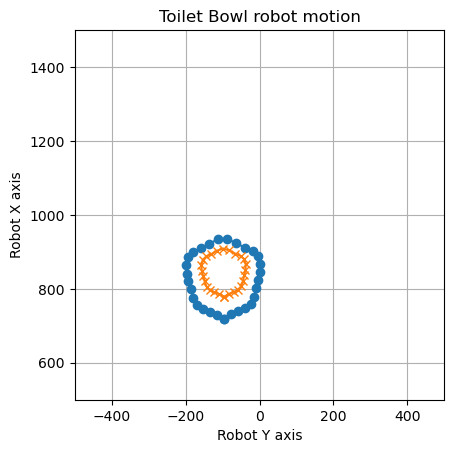

In [31]:
## Plot operating points for confirmation
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# plotting data
plt.plot(trajectory_outer[:,1], trajectory_outer[:,0], marker='o', linestyle='-')  # 点を'○'で、線で結ぶ
plt.plot(trajectory_inner[:,1], trajectory_inner[:,0], marker='x', linestyle='-')  # 点を'x'で、線で結ぶ


# Set the maximum and minimum values of Robot's Y-axis
#plt.xlim(-187 - 200, -187 + 200)
plt.xlim(-500, 500)

# Set the maximum and minimum values of Robot's X-axis
#plt.ylim(700 - 350, 700)
plt.ylim(500, 1500)

# Set aspect ratio equal
plt.gca().set_aspect('equal', adjustable='box')


# Add title and axis labels
plt.title('Toilet Bowl robot motion')
plt.xlabel('Robot Y axis')
plt.ylabel('Robot X axis')

# Show Grids
plt.grid(True)



In [32]:
###### Collection of methods to monitor whether the robot arm has completed its operation
def waitForMovingLeft():
    recent_state_left = 99 #sentinel loop method.
    while recent_state_left != 2:
        print(f"left state::{recent_state_left}")
        time.sleep(1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_state_left = xarm_left_state_subscriber.xarm_state.state

def waitForMovingRight():
    recent_state_right = 99 #sentinel loop method.
    while recent_state_right != 2:
        print(f"right state:{recent_state_right}")
        time.sleep(1)
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_state_right = xarm_right_state_subscriber.xarm_state.state

def waitForMovingBoth():
    ### TODO: If you use mode==5, it will not stop endlessly, so put some kind of validation.
    recent_state_left = 99 #sentinel loop method.
    recent_state_right = 99 #sentinel loop method.
    while recent_state_left != 2 and recent_state_right != 2:
        print(f"left state::{recent_state_left}")
        print(f"right state::{recent_state_right}")
        time.sleep(1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_state_left = xarm_left_state_subscriber.xarm_state.state
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_state_right = xarm_right_state_subscriber.xarm_state.state

In [33]:
### Collection of methods to monitor whether the mode setting of the robot arm is complete
# TODO:Not very good quality.
def waitForModeChangeLeft(target_mode):
    recent_mode_left = 99 #sentinel loop method.
    while recent_mode_left != target_mode:
        print(f"left mode::{recent_mode_left}")
        time.sleep(0.1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_mode_left = xarm_left_state_subscriber.xarm_state.mode

def waitForModeChangeRight(target_mode):
    recent_mode_right = 99 #sentinel loop method.
    while recent_mode_right != target_mode:
        print(f"right mode:{recent_mode_right}")
        time.sleep(0.1)
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_mode_right = xarm_right_state_subscriber.xarm_state.mode

def waitForModeChangeBoth(target_mode):
    recent_mode_left = 99 #sentinel loop method.
    recent_mode_right = 99 #sentinel loop method.
    while recent_mode_left != target_mode and recent_mode_right != target_mode:
        print(f"left mode::{recent_mode_left}")
        print(f"right mode:{recent_mode_right}")
        time.sleep(0.1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_mode_left = xarm_left_state_subscriber.xarm_state.mode
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_mode_right = xarm_right_state_subscriber.xarm_state.mode

In [43]:
def set_safe_pose_2(change):
    xarm_right_setup_client.call_services(mode=0)
    xarm_left_setup_client.call_services(mode=0)
    
    safe_pose_2_right()
    safe_pose_2_left()

# Set widgets
set_safe_pose_2_button = widgets.Button(description="Safe Pose 2")
set_safe_pose_2_button.on_click(set_safe_pose_2)

# Show widgets
widgets.VBox([set_safe_pose_2_button])

In [35]:
## Safety posture for cleaning toilets.
## It is preferable to perform SAFE POSTURE 2 first.
def washSafePlace():
    # For safety, setting mode as 0
    xarm_right_setup_client.call_services(mode=0)
    xarm_left_setup_client.call_services(mode=0)
    
    xarm_right_service_client.send_move_cartesian_aa_request([ 550.0, -187.0, 500.0, 0.0, 0.0, 0.0],  100.0, 50.0, 0.0)
    time.sleep(0.1)
    xarm_left_service_client.send_move_cartesian_aa_request([  530.0, -120.0, 500.0, 0.0, 0.0, 0.0] , 100.0, 50.0, 0.0)

In [36]:

#####################################
# トイレ掃除用メソッド
#####################################

def rightHandJogMove():
    ## TODO: A bad-know implementation for use with velocity vector movements. 
    ## This is a response to the case where the first movement is processed as an abnormal posture if something is not moved.
    xarm_right_service_client.send_vel_request( -10.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    time.sleep(1)
    xarm_right_service_client.send_vel_request( 10.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    time.sleep(1)
    xarm_right_service_client.send_vel_request(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    time.sleep(1)

def rihgtHandToOriginPlace(pose):
    xarm_right_service_client.send_joint_move_request(pose, 0.20, 30.0, 0.0)

def moveFistTrajPointRight(trajXY):
    xarm_right_setup_client.call_services(mode=0)
    time.sleep(0.2)
    hand_pitch = 5.25748730e-01 ## IMPORTANT!! Processing of the head tool at an angle of about 30 degrees in the sense of increasing the reach length.
    xarm_right_service_client.send_move_cartesian_aa_request([ trajXY[0], trajXY[1], 600.0, 0.0, hand_pitch, 0.0],  100.0, 50.0, 0.0)

def moveBowlCenterRight(movespeed=0.20):
    ## IMPORTANT!! As a transit point before returning to the safety posture.Without it, abnormal postures are likely to occur.
    pose = [-1.3013648986816406, -0.7284491658210754, 0.277678519487381, 1.2147583961486816, -2.2611629962921143, 1.6684703826904297, 0.9717563390731812]
    xarm_right_service_client.send_joint_move_request(pose, movespeed, 30.0, 0.0)

In [37]:
## The process of opening the toilet cover.
## Due to the strength of the parts, we decided to move them at right angles instead of using an elliptical trajectory.
def toiletCoverOpen():
    coverOpenPlace = [  580.0, -160.0, 750.0, 0.0, 0.0, 0.0]
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 300.0, 500.0, 0.0)

    time.sleep(1)
    coverOpenPlace[1] += 90 #y
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 100.0, 300.0, 0.0)
    
    time.sleep(1)
    coverOpenPlace[2] -= 100 #z
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 100.0, 300.0, 0.0)
    
    time.sleep(1)
    coverOpenPlace[0] += 140 #x
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 100.0, 300.0, 0.0)


In [39]:
#######################################

# IMPORTANT!!! Incorrect initial posture will crack the frame.
def set_toiletCoverOpen(change):
    xarm_left_setup_client.call_services(mode=0)
    toiletCoverOpen()

# Set widgets
set_toiletCoverOpen_button = widgets.Button(description="toiletCoverOpen")
set_toiletCoverOpen_button.on_click(set_toiletCoverOpen)

# Show widgets
widgets.VBox([set_toiletCoverOpen_button])

In [40]:
# With the lid open, move to the cleaning start position.
washSafePlace()

In [41]:
## For checking alighment, try to set right hand position to 1st place of  1st latyer
moveFistTrajPointRight( trajectory_outer[0] )
waitForMovingRight()

right state:99


In [42]:
###############################################
#####   Cleaning behavior of toilet bowls　#### 
###############################################

count = 0

## Turn down the tool head 30 degrees for the purpose of increasing reach length. 
## TODO: double definition in some functions, so unify them
hand_pitch = 5.25748730e-01

## Implementation of similar as the sentinel loop method.
## Pack negative values in this section so that the first layer is also additive.
## If the initialization fails for some reason, it is expected to return an error in the judgment.
layer = -1 

## TODO:
for vcl in [vel_commands, vel_commands_inner]:
    count = 0 ## counting points of this layers traj
    layer += 1
    if vcl == vel_commands :
        traj_now = trajectory_outer
    elif vcl == vel_commands_inner :
        traj_now = trajectory_inner
    else:
        raise ValueError()
        
    ## Ajusting Right hand
    print(f"############# new layer :: {layer} #############")
    moveFistTrajPointRight( traj_now[0] ) ## Move to 1st Place of this layer
    waitForMovingRight()

    #### Cleaning toilet bowl movement 
    cleanHight = 600.0 if layer == 0 else 680.0
    spreyHight = 650.0 if layer == 0 else 700.0
    for vc in vcl:
        ### Implement spraying using left hand motion ###
        print("sprey cleaner by left hand")
        if ( (count == 0) or (count == int(len(vcl) / 2)) ):
            waitForMovingRight() ## IMPORTANT! For faster movement
    
            ### Numerical settings to switch spray operation at the start and at the halfway point.
            ### First half four points at the time of disclosure, second half four points at the time of half
            start_index = 0 if count == 0 else 4
            end_index   = 4 if count == 0 else 8
            
            ## Retreating right hand
            moveBowlCenterRight(movespeed=0.40)
            waitForMovingRight()
            safe_pose_2_right(movespeed=0.40)
            waitForMovingRight()

            ## Move left hand to beggning of sparying place
            xarm_left_service_client.send_move_cartesian_aa_request([  585.9, -120.0, 650.0, 0.0, 0.0, 0.0] , 300.0, 500.0, 0.0)
            waitForMovingLeft()

            for i in range(start_index, end_index):
                temp_count_i = int( (i  / 8 ) * len(vcl) )
                print(temp_count_i)
                dx = traj_now[ temp_count_i ][0]
                dy = traj_now[ temp_count_i ][1] + 260
                xarm_left_service_client.send_move_cartesian_aa_request([ dx, dy, spreyHight, 0.0, 0.0, 0.0] , 300.0, 500.0, 0.0)
                time.sleep(1)
                
            xarm_left_service_client.send_move_cartesian_aa_request([ 585.9, -120.0, 400.0, 0.0, 0.0, 0.0] , 300.0, 500.0, 0.0)
            waitForMovingLeft()
            
            ## For safety, retreating right hand to centor of bowl.
            moveBowlCenterRight(movespeed=0.40)
            waitForMovingRight()
            print("return back right hand process")

        ## Right hand to new position of cleaning toilet bowl
        newpose = [traj_now[count][0],traj_now[count][1], cleanHight, 0.0, hand_pitch, 0.0]
        print(f'{count}, {vc} , {newpose} , ') # debug
        xarm_right_service_client.send_move_cartesian_aa_request(newpose, 300.0, 500.0, 0.0, is_wait=False)

        count += 1

print(" ################## done ################## ")

############# new layer :: 0 #############
right state:99
right state:4
right state:1
right state:1
right state:1
right state:1
right state:1
sprey cleaner by left hand
right state:99
right state:99
right state:99
right state:1
right state:1
right state:1
right state:1
right state:1
left state::99
0
3
7
10
left state::99
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4
left state::4


KeyboardInterrupt: 

In [ ]:
# For safty move to safe position 2
xarm_right_setup_client.call_services(mode=0)
xarm_left_setup_client.call_services(mode=0)
time.sleep(2)
safe_pose_2_right()
safe_pose_2_left()
waitForMovingBoth()

In [ ]:
# For AGV safty move to safe position 1

xarm_right_setup_client.call_services(mode=0)
xarm_left_setup_client.call_services(mode=0)
safe_pose_right()
safe_pose_left()
waitForMovingBoth()

In [ ]:
# Show Widgets of "Back to Home"
widgets.VBox([execute_way_out_button])